In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

file_path = '/Users/chenyuqin/Desktop/21_fall_codes_and_relative/dsci551/project/data/train/train.csv'
df=pd.read_csv(file_path)
df = df[['PetID', 'PhotoAmt', 'AdoptionSpeed']]
train, test=df[:5000], df[14000:]

def generate_img(df):
    data, label = [], []
    img_root_path = '/Users/chenyuqin/Desktop/21_fall_codes_and_relative/dsci551/data/train_images/'
    # '0a0e8c15b-1.jpg'
    for i in tqdm(range(len(df))):
    # for i in tqdm(range(3)):
        item = df.iloc[i]
        petId, amount, adoptionSpeed =item
        for j in range(1, int(amount)+1):
            img_path = img_root_path + petId + '-' + str(j) + '.jpg'
            img = cv2.imread(img_path)
            img = cv2.resize(img, (300, 300))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #转成RGB
            # plt.imshow(img)
            img = np.transpose(img, [2, 0, 1])/255
            data.append((img, adoptionSpeed))
            # label.append(adoptionSpeed)
    # return data, label
    return data

# train_x, train_y = generate_img(train)
# test_x, test_y = generate_img(test)
train, test = generate_img(train), generate_img(test)

100%|██████████| 993/993 [00:20<00:00, 49.33it/s]


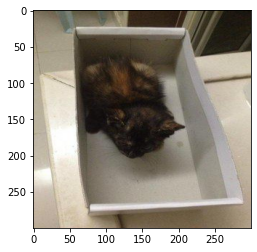

In [2]:
show = np.transpose(train[2][0], [1,2,0])
plt.imshow(show)

In [3]:
batch_size = 1
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=4)

In [4]:
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torch

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, 5)
        self.conv2 = nn.Conv2d(4, 4, 5)
        self.conv3 = nn.Conv2d(4, 8, 5)
        self.conv4 = nn.Conv2d(8, 8, 5)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(8*16*16, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # print('1', x.shape)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        # print('2', x.shape)
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout1(x)
        # print('3', x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print('4', x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        # print('5', x.shape)
        x = F.relu(self.fc2(x))
        # print('6', x.shape)
        return x

net = Net()

# criterion = nn.BCELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [5]:
torch.save(net, 'cnn.pkl')

In [6]:
cnn = torch.load('cnn.pkl')

In [1]:
train_losses, test_losses = [], []
predicts = []
for epoch in range(3):
    running_loss = 0.0
    i=0
    train_loss, test_loss = [], []
    for data in train:
        inputs, labels = data
        inputs = torch.from_numpy(np.reshape(inputs, (1,3,300,300))).float()
        labels = torch.from_numpy(np.reshape(labels, (1,1))).float()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        running_loss += loss.item()
        print('epoch:%d, step:%5d loss: %.3f' % (epoch + 1, i + 1, running_loss))
        i+=1
        running_loss = 0.0
    net.eval()
    predicts = []
    for data in test:
        inputs, labels = data
        inputs = torch.from_numpy(np.reshape(inputs, (1,3,300,300))).float()
        labels = torch.from_numpy(np.reshape(labels, (1,1))).float()
        outputs = net(inputs)
        predicts.append(outputs)
        loss = criterion(outputs, labels)
        test_loss.append(loss.item())
    train_losses.append(np.average(train_loss))
    test_losses.append(np.average(test_loss))

torch.save(net, 'cnn.pkl')

NameError: name 'train' is not defined

In [ ]:
fig, axes = plt.subplots(figsize=(7, 5))
axes.plot(range(1, len(train_losses)+1), train_losses, label='train')
axes.plot(range(1, len(test_losses)+1), test_losses, label='test')
axes.legend()
plt.show()

In [ ]:
print('test loss (mse):')
print(test_losses[-1])
print('predict')
print(predicts[-1])